In [38]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import itertools

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

pio.renderers.default = "iframe"

In [45]:
def read_config(path: Path) -> Dict:
    with path.open("r") as config_file:
        config = yaml.safe_load(config_file)
    return config


def read_configs(base_path: str, spark_session: SparkSession) -> pyspark.RDD:
    completed_filenames = list(Path(base_path).glob("*/completed.txt"))
    configs = map(lambda x: x.parent / "config.yaml", completed_filenames)
    configs = map(read_config, configs)
    return spark_session.sparkContext.parallelize(configs)


def create_configs_df(configs: pyspark.RDD) -> DataFrame:
    config_columns = [
        "simulation_id",
        "slope",
        "r_stat_multiplier",
        "effective_radius_multiplier",
        "min_rim_percentage"
    ]
    return configs.map(lambda x: {k: v for k, v in x.items() if k in config_columns}).toDF().cache()
    

def quantize_value(value: float, delta: float) -> float:
    return np.round(int(np.round(value / delta, decimals=5)) * delta, decimals=5)


def get_min_max_n_buckets(column: str, delta: float, df) -> Tuple[float, float, int]:
    min_max_df = df.select(F.min(column), F.max(column)).toPandas()
    
    min_val = quantize_value(min_max_df.iloc[0, 0], delta)
    max_val = quantize_value(min_max_df.iloc[0, 1], delta)
    n_buckets = int(np.round((max_val - min_val) / delta, decimals=5)) + 1

    return min_val, max_val, n_buckets

def get_confidence_intervals(train: DataFrame,
                             test: DataFrame,
                             predictor_variables: List[str],
                             bandwidths: pd.DataFrame,
                             spark_session: SparkSession) -> pd.DataFrame:
    train.createOrReplaceTempView("train")
    test.createOrReplaceTempView("test")
    
    bandwidths_df = spark_session.createDataFrame(bandwidths).cache()
    bandwidths_df.createOrReplaceTempView("bandwidths")

    # Trick it into caching and broadcasting
    bandwidths_df.count()

    simulation_id_present = "simulation_id" in test.columns
    
    group_by_clause = ",\n ".join([f"te.{x}" for x in predictor_variables] + [f"b.{x}" for x in bandwidths.columns])

    if "target" in test.columns:
        group_by_clause += "\n, te.target"
        target_select_clause = "te.target AS target,"
    else:
        target_select_clause = ""
        
    if simulation_id_present:
        simulation_id_clause = "AND tr.simulation_id <> te.simulation_id\n"
        bandwidths_select_clause = "te.simulation_id AS simulation_id, te.crater_id AS crater_id,\n"
        group_by_clause += "\n, te.simulation_id, te.crater_id"
    else:
        simulation_id_clause = ""
        bandwidths_select_clause = ""


    test_select_clause = ""
    bandwidth_clauses = "1=1 "
    for var in predictor_variables:
        test_select_clause += f"te.{var} as test_{var},\n"
        if var in bandwidths.columns:
            bandwidth_clauses += f"AND tr.{var} BETWEEN (te.{var} - b.{var}) AND (te.{var} + b.{var})\n"

    for var in predictor_variables:
        bandwidths_select_clause += f"b.{var} as bandwidth_{var},\n"

    query = f"""
    SELECT
        {test_select_clause}
        {bandwidths_select_clause}
        {target_select_clause}
        mean(tr.target) as target_mean,
        count(tr.target) as n_obs,
        count(distinct tr.simulation_id) as n_unique_sims,
        approx_percentile(tr.target, array(0.025, 0.975), 5000) as percentiles
    FROM
        test te
        INNER JOIN bandwidths b
        LEFT JOIN train tr
            ON {bandwidth_clauses}
    WHERE
        1=1
        {simulation_id_clause}
    GROUP BY
        {group_by_clause}
    """
    result = spark.sql(query)

    return result.toPandas()


def create_objective_function(train: DataFrame,
                              test: DataFrame,
                              predictor_variables: List[str],
                              spark: SparkSession):
    """
    Creates an objective function for HyperOpt optimization
    """
    def objective_function(args):
        min_obs = 100
        n_too_many_obs = 500000
        
        bandwidths_data = [[args[f"bandwidth_{x}"] for x in predictor_variables]]
        bandwidths = pd.DataFrame(bandwidths_data, columns=predictor_variables)
        
        result = get_confidence_intervals(train, test, predictor_variables, bandwidths, spark)

        ci_high = result.percentiles.map(lambda x: x[-1])
        ci_low = result.percentiles.map(lambda x: x[0])
        orders_of_magnitude_rms = np.sqrt((np.log10(ci_high / ci_low) ** 2).mean())
        orders_of_magnitude = np.log10(ci_high / ci_low).mean()
        orders_of_magnitude_stdev = np.log10(ci_high / ci_low).std()
        mean_n_unique_sims = result.n_unique_sims.mean()
        mean_n_obs = result.n_obs.mean()
        
        percent_inside_ci = ((result.target >= ci_low) & (result.target <= ci_high)).mean()

        # Penalize if more or less than 5% are outside of the CI
        deviance_from_95 = np.abs(0.95 - percent_inside_ci)
        deviance_loss_multiplier = 1.0 if deviance_from_95 < 0.01 else 1 + deviance_from_95 * 10.0
        
        # Penalize for the fraction with too few observations
        too_few = result.n_obs[(result.n_obs < min_obs) | (result.n_obs.isna())]
        n_obs_loss_multiplier = 1 + too_few.mean() * 100 if too_few.shape[0] > 0 else 1.0

        # Penalize for the fraction with too many observations
        too_many = result.n_obs > n_too_many_obs
        n_too_many_obs_loss_multiplier = 1 + too_many.mean() * 10 if too_many.shape[0] > 0 else 1.0

        loss = orders_of_magnitude_rms * deviance_loss_multiplier * n_obs_loss_multiplier * n_too_many_obs_loss_multiplier

        print(f"{args}, {loss:.3f}, {orders_of_magnitude:.4f}, {orders_of_magnitude_stdev:.4f}, {orders_of_magnitude_rms:.4f}, {n_obs_loss_multiplier:.4f}, {n_too_many_obs_loss_multiplier:.4f}, {deviance_loss_multiplier:.4f}, {mean_n_unique_sims}, {mean_n_obs:.4f}, ")
        
        return {
            "loss": loss,
            "params": args,
            "orders_of_magnitude": orders_of_magnitude,
            "orders_of_magnitude_rms": orders_of_magnitude_rms,
            "n_obs_loss_multiplier": n_obs_loss_multiplier,
            "deviance_loss_multiplier": deviance_loss_multiplier,
            "mean_n_unique_sims": mean_n_unique_sims,
            "mean_n_obs": mean_n_obs,
            "status": STATUS_OK
        }
        
    return objective_function

In [3]:
def setup_dataset(data: DataFrame,
                  configs: DataFrame,
                  predictor_variables: List[str],
                  target: str,
                  spark: SparkSession):
    data.createOrReplaceTempView("data")
    configs.createOrReplaceTempView("configs")
    
    # Join data and config
    data_and_config_select_clause = ",\n".join(["data.simulation_id AS simulation_id"] + predictor_variables)
    data_and_config_select_clause += f",\n {target} as target"
    query = f"""
    SELECT
        {data_and_config_select_clause}
    FROM
        data
        INNER JOIN configs
            ON data.simulation_id = configs.simulation_id
    """
    data_and_configs = spark.sql(query)

    return data_and_configs


def setup_datasets_for_optimization(data: DataFrame,
                                    configs: DataFrame,
                                    test_simulations_fraction: float,
                                    predictor_variables: List[str],
                                    target: str,
                                    train_sample_fraction: float,
                                    n_test_observations: int,
                                    spark: SparkSession,
                                    cache_train: bool = True,
                                    cache_test: bool = True):
    simulation_ids = list(configs_df.select("simulation_id").toPandas().drop_duplicates().simulation_id.sort_values())
    test_simulation_ids = set(np.random.choice(simulation_ids, int(configs.count() * test_simulations_fraction), replace=False))
    
    train = setup_dataset(data, configs.where(~F.col("simulation_id").isin(test_simulation_ids)), predictor_variables, target, spark)
    train = train.sample(train_sample_fraction)

    if cache_train:
        train = train.cache()
        train.count()
    train.createOrReplaceTempView("train")

    test = setup_dataset(data, configs.where(F.col("simulation_id").isin(test_simulation_ids)), predictor_variables, target, spark)
    test = test.drop("simulation_id")
    test_count = test.count()

    # Need to sample a few more because Spark's sampling is not precise
    test = test.sample(min(n_test_observations / test_count * 1.5, 1.0)).limit(n_test_observations)
    
    if cache_test:
        test = test.cache()
        test.count()
    test.createOrReplaceTempView("test")
    
    return train, test

In [4]:
n_cores = 26

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

23/12/11 18:25:14 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
23/12/11 18:25:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 18:25:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Prepare and save the dataset to disk

In [5]:
base_path = "/data/saturation/n_craters_stop_condition_20230918"

In [6]:
r_stat = 5
study_region_size = 4000 * 4000 / r_stat ** 2

configs_df = create_configs_df(read_configs(base_path, spark))
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")

# State c2c nn dist in terms of r_stat and log-scale
data = data.select(
    "*",
    F.log10(F.col("center_to_center_nearest_neighbor_distance_mean") / F.lit(r_stat)).alias("log_mean_c2c_nn_dist"),
    F.log10("areal_density").alias("log_ad"),
    (F.col("n_craters_in_study_region") / F.col("n_craters_added_in_study_region")).alias("information_remaining")
)

In [26]:
target = "n_craters_added_in_study_region"
predictor_variables = [
    "slope",
    "log_mean_c2c_nn_dist",
    "log_ad"
]

params_sets = [
    # {
    #     "n_test_samples": 1000,
    #     "train_sample_fraction": 0.05,
    # },
    # {
    #     "n_test_samples": int(1e9),
    #     "train_sample_fraction": 0.05,
    # },
    # {
    #     "n_test_samples": int(1e9),
    #     "train_sample_fraction": 0.25,
    # },
    {
        "n_test_samples": int(1e9),
        "train_sample_fraction": 1.00,
    },
    # {
    #     "n_test_samples": 1000,
    #     "train_sample_fraction": 0.1,
    # },
    # {
    #     "n_test_samples": 1000,
    #     "train_sample_fraction": 0.25,
    # },
    # {
    #     "n_test_samples": 1000,
    #     "train_sample_fraction": 1.0,
    # },
    # {
    #     "n_test_samples": 5000,
    #     "train_sample_fraction": 0.05,
    # },
    # {
    #     "n_test_samples": 5000,
    #     "train_sample_fraction": 0.1,
    # },
    # {
    #     "n_test_samples": 5000,
    #     "train_sample_fraction": 0.25,
    # },
    # {
    #     "n_test_samples": 10000,
    #     "train_sample_fraction": 0.05,
    # },
    # {
    #     "n_test_samples": 10000,
    #     "train_sample_fraction": 0.1,
    # },
    # {
    #     "n_test_samples": 10000,
    #     "train_sample_fraction": 0.25,
    # },
    # {
    #     "n_test_samples": 10000,
    #     "train_sample_fraction": 0.1,
    # },
    # {
    #     "n_test_samples": 10000,
    #     "train_sample_fraction": 1,
    # },
]

data_subset = data.where(
    (F.col("information_remaining") > F.lit(0.25))
    & (F.col("n_craters_added_in_study_region") > F.lit(50))
)

for params in params_sets:
    train_sample_fraction = params["train_sample_fraction"]
    n_test_samples = params["n_test_samples"]

    train, test = setup_datasets_for_optimization(
        data_subset,
        configs_df,
        0.1,
        predictor_variables,
        target,
        train_sample_fraction,
        n_test_samples,
        spark,
        cache_train=False,
        cache_test=False
    )

    train.coalesce(500).write.format("parquet").mode("overwrite").save(f"data/train_{train_sample_fraction:.3f}_{n_test_samples}.parquet")
    test.coalesce(50).write.format("parquet").mode("overwrite").save(f"data/test_{train_sample_fraction:.3f}_{n_test_samples}.parquet")

## Calibrating of bandwidths

In [ ]:
target = "n_craters_added_in_study_region"
predictor_variables = [
    "slope",
    "log_mean_c2c_nn_dist",
    "log_ad"
]

# Force caching of train and test data, as they are small
train = spark.read.parquet("data/train_0.050_1000.parquet").cache()
train.count()

test = spark.read.parquet("data/test_0.050_1000.parquet").cache()
test.count()

trials = Trials()
space = {
    "bandwidth_slope": hp.uniform("bandwidth_slope", 0.05, 0.3),
    "bandwidth_log_mean_c2c_nn_dist": hp.uniform("bandwidth_log_mean_c2c_nn_dist", 0.0005, 0.2),
    "bandwidth_log_ad": hp.uniform("bandwidth_log_ad", 0.001, 0.3),
}

best = fmin(create_objective_function(train, test, predictor_variables, spark),
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=500)

In [ ]:
trials

In [ ]:
"""
Oddly good losses for 0.050_1000:
{'bandwidth_log_ad': 0.09507393547881537, 'bandwidth_log_mean_c2c_nn_dist': 0.004143332056813422, 'bandwidth_slope': 0.2}, 5.547, 1.4063, 0.3337, 1.4453, 1.0000, 3.8381, 1.0000, 972.1454918032787, 380108.4395, 
{'bandwidth_log_ad': 0.0734955411086102, 'bandwidth_log_mean_c2c_nn_dist': 0.0038103947728301826, 'bandwidth_slope': 0.2}, 3.836, 1.4028, 0.3352, 1.4422, 1.0000, 2.6598, 1.0000, 878.1967213114754, 299167.2951,     

For 0.100_1000:
{'bandwidth_log_ad': 0.10846260454421022, 'bandwidth_log_mean_c2c_nn_dist': 0.0018803208882686748, 'bandwidth_slope': 0.2}, 6.136, 1.3785, 0.3344, 1.4185, 1.0000, 4.3260, 1.0000, 991.5437636761488, 398640.2495,           
"""

## Scoring Dione Surfaces

In [68]:
# train = spark.read.parquet("data/train_0.250_1000.parquet")
# train = spark.read.parquet("data/train_1.000_1000.parquet")
train = spark.read.parquet(f"data/train_1.000_{int(1e9)}.parquet")

In [75]:
target = "n_craters_added_in_study_region"
predictor_variables = [
    "slope",
    "log_mean_c2c_nn_dist",
    "log_ad"
]

observation_dee = {
    "slope": 2.10,
    "log_mean_c2c_nn_dist": 0.8136,
    "log_ad": np.log10(0.06)
}

observation_dsp = {
    "slope": 2.66,
    "log_mean_c2c_nn_dist": 0.6685,
    "log_ad": np.log10(0.13)
}

observation_dicp = {
    "slope": 2.08,
    "log_mean_c2c_nn_dist": 0.9338405903389017,
    "log_ad": np.log10(0.31)
}

observation_ddcp = {
    "slope": 2.15,
    "log_mean_c2c_nn_dist": 0.6685,
    "log_ad": np.log10(0.35)
}

# bandwidths_data = [
#     # [0.1, 0.002, 0.30],
#     # [0.1, 0.001, 0.30],
#     # [0.1, 0.0005, 0.30],
#     # [0.1, 0.0001, 0.30],
    
#     # [0.1, 0.005, 0.30],
#     # [0.1, 0.0025, 0.30],
#     # [0.1, 0.005, 0.15],
#     # [0.1, 0.0025, 0.15],

#     # [0.1, 0.01, 0.15],
#     # [0.1, 0.05, 0.15],
#     # [0.1, 0.02, 0.30],

#     # This set relatively successful
#     # Wide seems to be good
#     # [0.15, 0.05, 0.25],
#     # [0.15, 0.075, 0.25],
#     # [0.15, 0.1, 0.25],

#     [0.1, 0.05, 0.2],
#     [0.1, 0.1, 0.2],
# ]
# bandwidths = pd.DataFrame(bandwidths_data, columns=["slope", "log_mean_c2c_nn_dist", "log_ad"])

bandwidths_data = [
    [0.1, 0.05, 0.2],
]
bandwidths = pd.DataFrame(bandwidths_data, columns=["slope", "log_mean_c2c_nn_dist", "log_ad"])

sensitivity_steps = {
    "slope": 0.1,
    "log_mean_c2c_nn_dist": 0.05,
    "log_ad": 0.2
}

n_steps = 2

In [76]:
# Dione Region 1: DEE
observation = observation_dee

test = pd.DataFrame(
    map(dict, itertools.product(*[
        [
            (k, observation[k] + x * sensitivity_steps[k])
            for x in range(-n_steps, n_steps + 1)
        ]
        for k, v in observation.items()
    ]))
)

test = spark.createDataFrame(test).cache()
test.count()

result = get_confidence_intervals(train, test, predictor_variables, bandwidths, spark)
dee_result = result
result

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
0,2.1,0.7136,-0.721849,0.1,0.05,0.2,16219.344143,7717707,897,"[6566, 32240]"
1,2.2,0.8136,-0.971849,0.1,0.05,0.2,6370.400496,2285602,835,"[3571, 18666]"
2,2.1,0.7636,-1.471849,0.1,0.05,0.2,NaN,0,0,None
3,2.0,0.7136,-1.221849,0.1,0.05,0.2,NaN,0,0,None
4,2.3,0.7136,-1.721849,0.1,0.05,0.2,NaN,0,0,None
...,...,...,...,...,...,...,...,...,...,...
120,2.1,0.7636,-1.221849,0.1,0.05,0.2,NaN,0,0,None
121,2.2,0.8636,-1.721849,0.1,0.05,0.2,NaN,0,0,None
122,2.3,0.8636,-1.721849,0.1,0.05,0.2,NaN,0,0,None
123,1.9,0.9136,-1.721849,0.1,0.05,0.2,NaN,0,0,None


In [77]:
result = dee_result
observation = observation_dee
result.to_parquet("data/dee.parquet")

result[
    (result.test_slope == observation["slope"])
    & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
    & (result.test_log_ad == observation["log_ad"])
]

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
76,2.1,0.8136,-1.221849,0.1,0.05,0.2,3662.908225,18066,79,"[3246, 4281]"


In [78]:
np.log10(
    result[
        (result.test_slope == observation["slope"])
        & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
        & (result.test_log_ad == observation["log_ad"])
    ].percentiles.iloc[0]
)

array([3.51134852, 3.63154523])

In [79]:
# Dione region 2: DSP
observation = observation_dsp

test = pd.DataFrame(
    map(dict, itertools.product(*[
        [
            (k, observation[k] + x * sensitivity_steps[k])
            for x in range(-n_steps, n_steps + 1)
        ]
        for k, v in observation.items()
    ]))
)

test = spark.createDataFrame(test).cache()
test.count()

result = get_confidence_intervals(train, test, predictor_variables, bandwidths, spark)
dsp_result = result
result

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
0,2.56,0.5685,-1.386057,0.1,0.05,0.2,NaN,0,0,None
1,2.66,0.5685,-1.386057,0.1,0.05,0.2,NaN,0,0,None
2,2.86,0.7685,-1.136057,0.1,0.05,0.2,6206.416277,2808787,880,"[4196, 9761]"
3,2.56,0.7185,-1.386057,0.1,0.05,0.2,NaN,0,0,None
4,2.76,0.6685,-0.886057,0.1,0.05,0.2,18765.496564,8802820,912,"[7298, 49201]"
...,...,...,...,...,...,...,...,...,...,...
120,2.76,0.7685,-0.636057,0.1,0.05,0.2,9231.930285,85075,58,"[4878, 14993]"
121,2.66,0.6685,-1.386057,0.1,0.05,0.2,NaN,0,0,None
122,2.76,0.7685,-0.386057,0.1,0.05,0.2,NaN,0,0,None
123,2.46,0.6185,-1.386057,0.1,0.05,0.2,NaN,0,0,None


In [80]:
result = dsp_result
observation = observation_dsp
result.to_parquet("data/dsp.parquet")

result[
    (result.test_slope == observation["slope"])
    & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
    & (result.test_log_ad == observation["log_ad"])
]

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
87,2.66,0.6685,-0.886057,0.1,0.05,0.2,17744.125191,7691605,893,"[7302, 45346]"


In [81]:
np.log10(
    result[
        (result.test_slope == observation["slope"])
        & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
        & (result.test_log_ad == observation["log_ad"])
    ].percentiles.iloc[0]
)

array([3.86344183, 4.65653898])

In [82]:
# Dione region 3: DICP
observation = observation_dicp

test = pd.DataFrame(
    map(dict, itertools.product(*[
        [
            (k, observation[k] + x * sensitivity_steps[k])
            for x in range(-n_steps, n_steps + 1)
        ]
        for k, v in observation.items()
    ]))
)

test = spark.createDataFrame(test).cache()
test.count()

result = get_confidence_intervals(train, test, predictor_variables, bandwidths, spark)
dicp_result = result
result

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
0,2.08,1.033841,-0.258638,0.1,0.05,0.2,NaN,0,0,None
1,2.18,0.833841,-1.008638,0.1,0.05,0.2,5114.282545,1793514,828,"[3206, 11502]"
2,1.98,0.983841,-0.008638,0.1,0.05,0.2,NaN,0,0,None
3,1.88,0.933841,-0.508638,0.1,0.05,0.2,4125.406244,539811,442,"[2387, 7781]"
4,2.18,1.033841,-0.008638,0.1,0.05,0.2,NaN,0,0,None
...,...,...,...,...,...,...,...,...,...,...
120,2.18,0.983841,-0.008638,0.1,0.05,0.2,NaN,0,0,None
121,1.98,0.883841,-1.008638,0.1,0.05,0.2,3866.902669,1128874,795,"[2533, 7994]"
122,2.28,0.933841,-1.008638,0.1,0.05,0.2,2859.755098,783441,844,"[2074, 3866]"
123,1.98,0.933841,-0.258638,0.1,0.05,0.2,5011.295182,3591,5,"[2643, 10320]"


In [83]:
result = dicp_result
observation = observation_dicp
result.to_parquet("data/dicp.parquet")

result[
    (result.test_slope == observation["slope"])
    & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
    & (result.test_log_ad == observation["log_ad"])
]

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
101,2.08,0.933841,-0.508638,0.1,0.05,0.2,3911.39771,72651,85,"[2382, 6334]"


In [84]:
np.log10(
    result[
        (result.test_slope == observation["slope"])
        & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
        & (result.test_log_ad == observation["log_ad"])
    ].percentiles.iloc[0]
)

array([3.37694176, 3.80167806])

In [85]:
# Dione region 4: DDCP
observation = observation_ddcp

test = pd.DataFrame(
    map(dict, itertools.product(*[
        [
            (k, observation[k] + x * sensitivity_steps[k])
            for x in range(-n_steps, n_steps + 1)
        ]
        for k, v in observation.items()
    ]))
)

test = spark.createDataFrame(test).cache()
test.count()

result = get_confidence_intervals(train, test, predictor_variables, bandwidths, spark)
ddcp_result = result
result

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
0,2.35,0.7685,-0.955932,0.1,0.05,0.2,8473.935916,3211023,822,"[4419, 23719]"
1,1.95,0.7685,0.044068,0.1,0.05,0.2,NaN,0,0,None
2,1.95,0.6685,0.044068,0.1,0.05,0.2,NaN,0,0,None
3,2.35,0.6185,-0.205932,0.1,0.05,0.2,29310.610643,379444,78,"[13304, 50346]"
4,2.25,0.6685,-0.205932,0.1,0.05,0.2,22920.507958,218457,75,"[11665, 41434]"
...,...,...,...,...,...,...,...,...,...,...
120,2.05,0.7685,-0.705932,0.1,0.05,0.2,11876.349895,6541555,921,"[4950, 24481]"
121,2.25,0.5685,-0.205932,0.1,0.05,0.2,38161.793208,6011037,398,"[17702, 63973]"
122,2.15,0.5685,0.044068,0.1,0.05,0.2,NaN,0,0,None
123,2.15,0.6685,0.044068,0.1,0.05,0.2,NaN,0,0,None


In [86]:
result = ddcp_result
observation = observation_ddcp
result.to_parquet("data/ddcp.parquet")

result[
    (result.test_slope == observation["slope"])
    & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
    & (result.test_log_ad == observation["log_ad"])
]

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target_mean,n_obs,n_unique_sims,percentiles
61,2.15,0.6685,-0.455932,0.1,0.05,0.2,21460.968393,12224253,835,"[9068, 39591]"


In [87]:
np.log10(
    result[
        (result.test_slope == observation["slope"])
        & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
        & (result.test_log_ad == observation["log_ad"])
    ].percentiles.iloc[0]
)

array([3.95751151, 4.59759647])

In [ ]:
# Reload results
dee_result = pd.read_parquet("data/dee.parquet")
ddcp_result = pd.read_parquet("data/ddcp.parquet")
dsp_result = pd.read_parquet("data/dsp.parquet")
dicp_result = pd.read_parquet("data/dicp.parquet")

In [ ]:
dee_result["percentiles"] = [[int(y) for y in x.strip("[]").split(", ")] if type(x) != float else None for x in dee_result.percentiles]
ddcp_result["percentiles"] = [[int(y) for y in x.strip("[]").split(", ")] if type(x) != float else None for x in ddcp_result.percentiles]
dsp_result["percentiles"] = [[int(y) for y in x.strip("[]").split(", ")] if type(x) != float else None for x in dsp_result.percentiles]
dicp_result["percentiles"] = [[int(y) for y in x.strip("[]").split(", ")] if type(x) != float else None for x in dicp_result.percentiles]

In [ ]:
# Plots of orders of magnitude
observation = observation_dee
result = dee_result
result["orders_of_magnitude"] = [np.log10(x[1] / x[0]) if x else None for x in result.loc[:, "percentiles"]] 

r = result[
    (result.bandwidth_log_mean_c2c_nn_dist == 0.1)
    & (~result.orders_of_magnitude.isna())
].copy()
fig = px.scatter_3d(
    r,
    x="test_slope",
    y="test_log_mean_c2c_nn_dist",
    z="test_log_ad",
    color="orders_of_magnitude",
    size_max=1,
    width=1000,
    height=800
)
fig.update_traces(marker={"size":7})
fig.show()

In [ ]:
observation = observation_dsp
result = dsp_result
result["orders_of_magnitude"] = [np.log10(x[1] / x[0]) if x else None for x in result.loc[:, "percentiles"]] 

In [ ]:
result[
    #(result.bandwidth_log_mean_c2c_nn_dist == 0.1)
    (result.test_slope == observation["slope"])
    & (result.test_log_mean_c2c_nn_dist == observation["log_mean_c2c_nn_dist"])
    & (result.test_log_ad == observation["log_ad"])
]

## Scoring the selected parameters

In [ ]:
train = spark.read.parquet("data/train_0.250_10000.parquet")
test = spark.read.parquet("data/test_0.250_10000.parquet").limit(5000).cache()
test.count()

In [ ]:
target = "n_craters_added_in_study_region"
predictor_variables = [
    "slope",
    "log_mean_c2c_nn_dist",
    "log_ad"
]

bandwidths_data = [
    [0.1, 0.1, 0.2],
]
bandwidths = pd.DataFrame(bandwidths_data, columns=["slope", "log_mean_c2c_nn_dist", "log_ad"])

result = get_confidence_intervals(train, test, predictor_variables, bandwidths, spark)

In [ ]:
# result = pd.read_csv("data/scored.csv")
# # result["percentiles"] = [[int(y) for y in x.strip("[]").split(", ")] if type(x) != float else None for x in result.percentiles]
# result

In [ ]:
# result.to_csv("data/scored.csv")
result.to_parquet("data/scored.parquet")

In [ ]:
result = pd.read_parquet("data/scored.parquet")
result

In [ ]:
result["orders_of_magnitude"] = [np.log10(x[1] / x[0]) if x else None for x in result.loc[:, "percentiles"]] 

In [ ]:
plt.hist(result.target, bins=50)
plt.show()

In [ ]:
ci_high = result.percentiles.map(lambda x: x[-1])
ci_low = result.percentiles.map(lambda x: x[0])
inside_ci = ((result.target >= ci_low) & (result.target <= ci_high))
percent_inside_ci = inside_ci.mean()

In [ ]:
plt.scatter(
    
)

## Evaluating the model by ranges of N

In [145]:
train = spark.read.parquet(f"data/train_1.000_{int(1e9)}.parquet")
test = spark.read.parquet(f"data/test_1.000_{int(1e9)}.parquet").cache()
test.count()

23/12/13 18:29:27 WARN CacheManager: Asked to cache already cached data.


44821449

In [146]:
target = "n_craters_added_in_study_region"
predictor_variables = [
    "slope",
    "log_mean_c2c_nn_dist",
    "log_ad"
]

log_n_start = np.log10(100)
log_n_end = np.log10(200000)
n_steps = 25
n_tests_per_step = 1000
step_size = (log_n_end - log_n_start) / (n_steps - 1)


# bandwidths_data = [
#     [0.05, 0.01, 0.2],
# ]

# Result: CI's cover way more than 95%
# bandwidths_data = [
#     [0.1, 0.05, 0.2],
# ]
bandwidths = pd.DataFrame(bandwidths_data, columns=["slope", "log_mean_c2c_nn_dist", "log_ad"])

results = dict()
for step in range(n_steps):
    print(f"Step {step}...")

    log_n_target = log_n_start + step_size * step
    test_subset = test.where(
        test.target.between(10**(log_n_target - step_size / 2), 10**(log_n_target + step_size / 2))
    ).orderBy(F.rand()).limit(n_tests_per_step).cache()
    test_subset.count()

    r = get_confidence_intervals(train, test_subset, predictor_variables, bandwidths, spark)
    r["orders_of_magnitude"] = [np.log10(x[1] / x[0]) if x else None for x in r.loc[:, "percentiles"]]
    ci_high = r.percentiles.map(lambda x: x[-1] if x else None)
    ci_low = r.percentiles.map(lambda x: x[0] if x else None)
    r["inside_ci"] = ((r.target >= ci_low) & (r.target <= ci_high))
    
    print(f"% inside CI: {r.inside_ci.mean()}")
    print(f"Mean orders of magnitude: {r.orders_of_magnitude.mean()}")
    
    results[step] = r

Step 0...


% inside CI: 0.989
Mean orders of magnitude: 0.2713152728986867
Step 1...


% inside CI: 0.993
Mean orders of magnitude: 0.2595782471229612
Step 2...


% inside CI: 0.994
Mean orders of magnitude: 0.2555250006133206
Step 3...


% inside CI: 0.998
Mean orders of magnitude: 0.26242063828083734
Step 4...


% inside CI: 0.999
Mean orders of magnitude: 0.26532602745460243
Step 5...


% inside CI: 1.0
Mean orders of magnitude: 0.28948853585275064
Step 6...


% inside CI: 0.996
Mean orders of magnitude: 0.29722905604821426
Step 7...


% inside CI: 0.999
Mean orders of magnitude: 0.31806834205042406
Step 8...


% inside CI: 0.998
Mean orders of magnitude: 0.33855124525379837
Step 9...


% inside CI: 1.0
Mean orders of magnitude: 0.36826491532381983
Step 10...


% inside CI: 1.0
Mean orders of magnitude: 0.394818319228868
Step 11...


% inside CI: 1.0
Mean orders of magnitude: 0.43558568601286346
Step 12...


% inside CI: 1.0
Mean orders of magnitude: 0.5035713770078697
Step 13...


% inside CI: 1.0
Mean orders of magnitude: 0.6011607401735873
Step 14...


% inside CI: 0.999
Mean orders of magnitude: 0.6754384635847044
Step 15...


% inside CI: 0.993
Mean orders of magnitude: 0.6896561906884761
Step 16...


% inside CI: 0.99
Mean orders of magnitude: 0.6805433466783382
Step 17...


% inside CI: 0.992
Mean orders of magnitude: 0.6700092857780671
Step 18...


% inside CI: 0.993
Mean orders of magnitude: 0.6657386950680226
Step 19...


% inside CI: 1.0
Mean orders of magnitude: 0.6682099527385991
Step 20...


% inside CI: 1.0
Mean orders of magnitude: 0.6564869189583803
Step 21...


% inside CI: 0.997
Mean orders of magnitude: 0.6445813300740877
Step 22...


% inside CI: 0.999
Mean orders of magnitude: 0.6025686261197342
Step 23...


% inside CI: 0.994
Mean orders of magnitude: 0.5643653851274164
Step 24...


% inside CI: 0.941
Mean orders of magnitude: 0.48752082261030455


In [53]:
# old_results = results
# old_results_90_big = results
# results_only_two_vars = results

In [151]:
results = old_results

In [152]:
results[0]

,test_slope,test_log_mean_c2c_nn_dist,test_log_ad,bandwidth_slope,bandwidth_log_mean_c2c_nn_dist,bandwidth_log_ad,target,target_mean,n_obs,n_unique_sims,percentiles,orders_of_magnitude,inside_ci
0,1.012508,1.610245,-1.484640,0.05,0.01,0.2,87,105.427184,206,79,"[80, 131]",0.214181,True
1,1.017058,1.632794,-0.805597,0.05,0.01,0.2,115,107.396624,237,81,"[75, 158]",0.323596,True
2,1.020033,1.597333,-1.667125,0.05,0.01,0.2,104,107.906103,213,74,"[86, 129]",0.176091,True
3,1.023789,1.619961,-1.278511,0.05,0.01,0.2,99,102.841328,271,111,"[76, 128]",0.226396,True
4,1.025178,1.628437,-0.734946,0.05,0.01,0.2,107,112.350943,265,88,"[76, 158]",0.317843,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.997213,1.585225,-2.820358,0.05,0.01,0.2,113,107.966165,532,186,"[83, 133]",0.204774,True
496,2.997213,1.612469,-2.856010,0.05,0.01,0.2,102,97.252723,459,175,"[75, 117]",0.193125,True
497,2.998557,1.604194,-2.658034,0.05,0.01,0.2,105,106.144737,228,89,"[84, 128]",0.182931,True
498,2.998647,1.590755,-2.796287,0.05,0.01,0.2,116,106.600390,513,176,"[82, 130]",0.200129,True


In [153]:
all = pd.concat([x for x in results.values()], axis=0)
all.inside_ci.mean()

0.95552

In [154]:
all.orders_of_magnitude.mean()

0.4208581198833147

In [155]:
[results[x].inside_ci.mean() for x in range(len(results))]

[0.962,
 0.956,
 0.956,
 0.97,
 0.972,
 0.974,
 0.972,
 0.972,
 0.976,
 0.976,
 0.98,
 0.978,
 0.96,
 0.952,
 0.93,
 0.924,
 0.914,
 0.944,
 0.954,
 0.976,
 0.98,
 0.944,
 0.954,
 0.932,
 0.88]

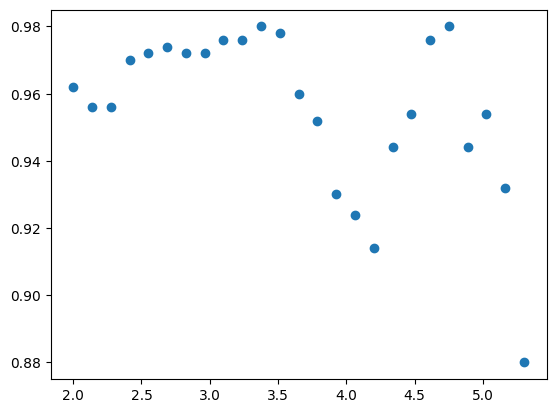

In [156]:
n_steps = 25
plt.scatter(
    [log_n_start + x * step_size for x in range(n_steps)],
    [results[x].inside_ci.mean() for x in range(n_steps)],
)

In [52]:
[results[x].orders_of_magnitude.mean() for x in range(len(results))]

[0.20716985662458037,
 0.19153630299530938,
 0.17775677841457962,
 0.18116778529638064,
 0.1845233291801273,
 0.19260354842055727,
 0.20431295714248934,
 0.21471583226670357,
 0.239116595142943,
 0.262771114650354,
 0.2755382153925822,
 0.31763235672714735,
 0.3748545215485606,
 0.45472578853896994,
 0.5478315302850524,
 0.5985740159110837,
 0.5970271733310689,
 0.5941245318271785,
 0.590371470135946,
 0.5927044674863442,
 0.5829517680883969,
 0.5693787680246708,
 0.5290933658927226,
 0.4754440199474316,
 0.40619791164495267]

### Visualization of log_N vs NN_d

In [32]:
def join_configs(data: DataFrame, configs: DataFrame) -> DataFrame:
    data.createOrReplaceTempView("data")
    configs.createOrReplaceTempView("configs")
    
    # Join data and config
    query = f"""
    SELECT
        *
    FROM
        data
        INNER JOIN configs
            ON data.simulation_id = configs.simulation_id
    """
    return spark.sql(query)

In [33]:
data_subset = data.where(
    (F.col("information_remaining") > F.lit(0.25))
    & (F.col("n_craters_added_in_study_region") > F.lit(50))
).sample(0.00025)

df = join_configs(data_subset, configs_df).toPandas()

In [34]:
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

In [43]:
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="slope",
    hover_data=["slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [74]:
# Trying a range selector
to_show = df.copy()
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])

range_x = [to_show.log_mean_c2c_nn_dist.min(), to_show.log_mean_c2c_nn_dist.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

## Plotting single simulations

In [91]:
cdf = configs_df.toPandas()

In [131]:
cdf

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
0,1.595722,0.713711,8.785218,5202,1.878941
1,1.572029,0.742029,6.240927,1742,1.670691
2,1.654870,0.417814,4.251724,7230,2.087161
3,1.696791,0.691715,8.746842,2442,1.027471
4,1.471475,0.263758,4.777187,4225,1.211729
...,...,...,...,...,...
9995,1.236832,0.619634,6.045127,1544,2.568607
9996,1.623665,0.291272,7.419121,7099,1.362784
9997,1.123434,0.314197,7.104084,4790,2.580947
9998,1.297770,0.450924,7.230221,4458,2.522814


In [110]:
df = data.where(
    (F.col("information_remaining") > F.lit(0.05))
    & (F.col("n_craters_added_in_study_region") > F.lit(50))
    & (df.simulation_id == 1742)
    # & (df.simulation_id == 7230)
)

In [111]:
n_pts = 10000
n_obs = df.count()

if n_obs > n_pts:
    sample_fraction = n_pts / n_obs
    df = df.sample(sample_fraction)

pandas_df = df.toPandas()

In [113]:
pandas_df

,crater_id,n_craters_added_in_study_region,n_craters_in_study_region,areal_density,areal_density_overlap_2,areal_density_overlap_3,center_to_center_nearest_neighbor_distance_mean,center_to_center_nearest_neighbor_distance_stdev,center_to_center_nearest_neighbor_distance_min,center_to_center_nearest_neighbor_distance_max,radius_mean,radius_stdev,z,za,simulation_id,log_mean_c2c_nn_dist,log_ad,information_remaining
0,1604,54,54,0.002003,0.000000,0.0,298.276861,122.912090,115.687759,628.273560,188.688671,8.784284,1.348726,1.364176,1742,1.775650,-2.698400,1.000000
1,1689,57,57,0.002137,0.000000,0.0,290.685157,116.639282,115.687759,628.273560,190.770194,8.793310,1.405518,1.422482,1742,1.764453,-2.670157,1.000000
2,1744,60,60,0.002184,0.000000,0.0,294.184264,117.196142,115.687759,628.273560,185.230341,8.612139,2.065276,2.083743,1742,1.769649,-2.660760,1.000000
3,2048,69,69,0.002501,0.000000,0.0,276.381547,124.559209,60.583805,668.350891,184.460928,8.495358,2.350282,2.373135,1742,1.742539,-2.601908,1.000000
4,2179,74,73,0.005958,0.000000,0.0,270.061549,126.832420,60.583805,668.350891,415.524670,16.572688,2.512326,2.568755,1742,1.732493,-2.224895,0.986486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10052,2566821,76904,4071,0.192203,0.004187,0.0,34.026138,16.344707,1.604586,170.164505,247.880829,11.576496,10.437355,25.360148,1742,0.832843,-0.716240,0.052936
10053,2566826,76906,4073,0.192217,0.004187,0.0,34.007696,16.349929,1.604586,170.164505,247.776661,11.574138,10.400624,25.323940,1742,0.832607,-0.716208,0.052961
10054,2566931,76912,4078,0.192247,0.004188,0.0,33.987944,16.339248,1.604586,170.164505,247.511596,11.567993,10.411306,25.347042,1742,0.832355,-0.716139,0.053022
10055,2567722,76922,4083,0.191561,0.004178,0.0,33.948309,16.323399,1.604586,170.164505,246.391630,11.530188,10.344192,25.218137,1742,0.831848,-0.717693,0.053080


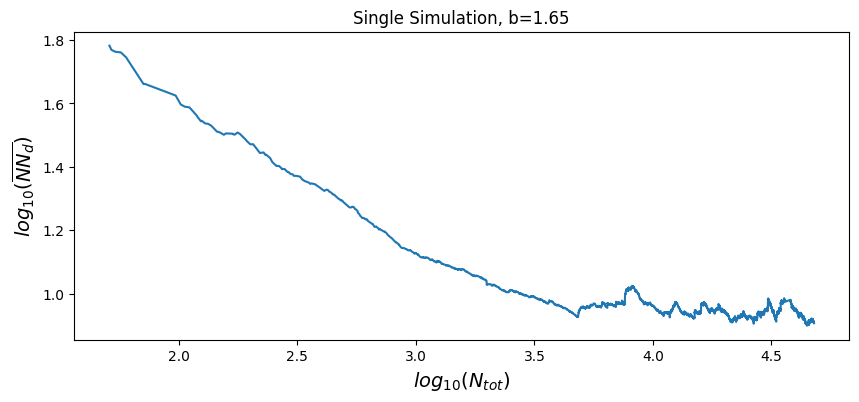

In [132]:
plt.figure(figsize=(10, 4))
plt.plot(
    np.log10(pandas_df.n_craters_added_in_study_region),
    pandas_df.log_mean_c2c_nn_dist,    
)
plt.title("Single Simulation, b=1.65")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(\overline{NN_d})$", size=14)
plt.show()

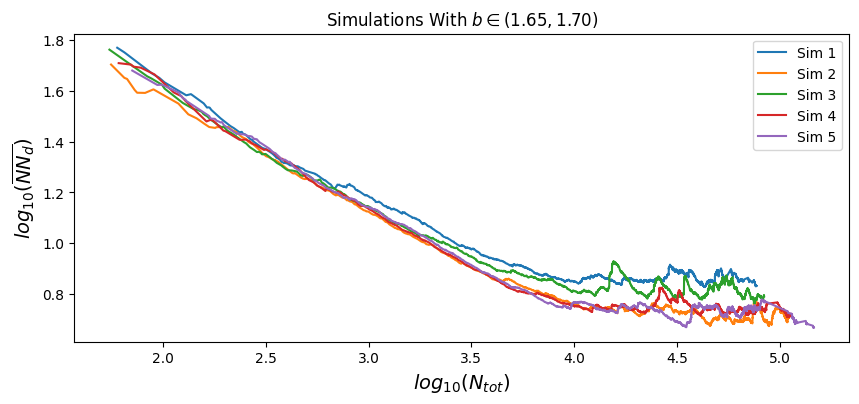

In [134]:
n_pts = 10000

simulation_ids = list(cdf[cdf.slope.between(1.66, 1.68)].sample(4).simulation_id)
simulation_ids = [1742] + simulation_ids

plt.figure(figsize=(10, 4))

for idx, simulation_id in enumerate(simulation_ids):
    df = data.where(
        (F.col("information_remaining") > F.lit(0.05))
        & (F.col("n_craters_added_in_study_region") > F.lit(50))
        & (df.simulation_id == simulation_id)
    )

    n_obs = df.count()
    sample_fraction = n_pts / n_obs
    df = df.sample(sample_fraction)
    pandas_df = df.toPandas()
    pandas_df = pandas_df.sort_values("n_craters_added_in_study_region")
    
    plt.plot(
        np.log10(pandas_df.n_craters_added_in_study_region),
        pandas_df.log_mean_c2c_nn_dist,
        label = f"Sim {idx + 1}"
    )

plt.title("Simulations With $b \in (1.65, 1.70)$")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(\overline{NN_d})$", size=14)
plt.legend()
plt.show()